<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#What-is-Firedrake?" data-toc-modified-id="What-is-Firedrake?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>What is Firedrake?</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Getting-started-on-Google's-colab" data-toc-modified-id="Getting-started-on-Google's-colab-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Getting started on Google's colab</a></span></li></ul></li><li><span><a href="#A-one-dimensional-problem" data-toc-modified-id="A-one-dimensional-problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>A one-dimensional problem</a></span><ul class="toc-item"><li><span><a href="#Problem-data" data-toc-modified-id="Problem-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Problem data</a></span></li><li><span><a href="#Define-the-mesh" data-toc-modified-id="Define-the-mesh-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Define the mesh</a></span></li><li><span><a href="#The-FEM-space" data-toc-modified-id="The-FEM-space-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>The FEM space</a></span></li><li><span><a href="#The-Weak-Form" data-toc-modified-id="The-Weak-Form-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>The Weak Form</a></span></li><li><span><a href="#Boundary-conditions" data-toc-modified-id="Boundary-conditions-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Boundary conditions</a></span></li><li><span><a href="#Solve" data-toc-modified-id="Solve-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Solve</a></span></li><li><span><a href="#Compute-errors" data-toc-modified-id="Compute-errors-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Compute errors</a></span></li><li><span><a href="#Plot-solutions" data-toc-modified-id="Plot-solutions-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Plot solutions</a></span></li></ul></li><li><span><a href="#A-fitted-mesh-in-1D" data-toc-modified-id="A-fitted-mesh-in-1D-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>A fitted mesh in 1D</a></span><ul class="toc-item"><li><span><a href="#Solver-as-a-function" data-toc-modified-id="Solver-as-a-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Solver as a function</a></span></li></ul></li><li><span><a href="#Other-things-Firedrake-can-and-cannot-do" data-toc-modified-id="Other-things-Firedrake-can-and-cannot-do-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Other things Firedrake can and cannot do</a></span></li></ul></div>

# A tutorial on solving singularly perturbed problems in Firedrake

**21st Workshop on Numerical Methods for Problems with Layer Phenomena**
   
[Niall Madden](https://www.niallmadden.ie/) and Sean Tobin, April 2025

You can access this notebook at:
* Jupyter notebook: https://www.niallmadden.ie/SPPs_Firedrake.ipynb
* HTML version: https://www.niallmadden.ie/SPPs_Firedrake.html

In this session, we introduce how to solve one-dimensional and two-dimensional singularly perturbed differential equations (SPDEs) on $(0,1)^d$, $d=1,2$ in Firedrake.

For a very basic introduction to **Firedrake**, see https://niallmadden.ie/IntroToFiredrake
For more advanced topics, see https://www.firedrakeproject.org/documentation.html

While this session will include the very fundamentals of using Firedrake for solving PDEs, there will be an emphasis on topics particular to SPDEs:
* constructing layer-adapted meshes.
* error estimation in various norms.

## What is Firedrake?

According to the documentation: _Firedrake is an automated system for the solution of partial differential equations using the finite element method (FEM). Firedrake uses sophisticated code generation to provide mathematicians, scientists, and engineers with a very high productivity way to create sophisticated high performance simulations._

Crucial:
* You define a mesh, or use a standard mesh generator;
* Define a elements, and a function space on that mesh;
* **Express the weak form of a PDE**
* Call a solver
* Compute errors and/or visualise solutions.


### Background

Firedrake began in 2014 is as a "reimagining" of `FEniCS`. 
* It uses the FEniCS _Unified Form Language_ (UFL)  to express PDEs. 

* Boasts sophisticated, programmable solvers through "_seamless_" coupling with PETSc.

* Triangular, quadrilateral, and tetrahedral unstructured meshes.

* Vast array  of finite element spaces.

Etc. 

(To the user, may seem a little closer the FEniCS than FEniCSx).

### Getting started on Google's colab

For serious work, you should install Firedrake on your own system. That is not too hard to do: as of last month, there is a `pip install` approach.

But to get started, we'll try Google colab: https://colab.google/

Note the incantation needed to install Firedrake. Can take several minutes to run:

In [1]:
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


We'll also use the `numpy` and `matplotlib` modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## A one-dimensional problem

The first problem we'll solve is this ODE: _find $u(x)$ such that_
$$-\varepsilon^2 u'' + r(x)u  = f(x) \text{ on } (0,1), \qquad\text{ with } u(0)=u(1)=0.$$

The weak $$\varepsilon^2 (u',v') + (ru,v) = (f,v),$$
where here $(u,v):=\int_0^1 u(x)v(x) dx$, is the usual $L^2$ inner product.

The specific example we'll consider will have $r(x) \equiv 1$ and $f(x)=e^x$.

We'll solve this problem using a stardard $P^1$ (continuous) Galerkin method.


###  Problem data

In [15]:
epsilon = Constant(0.1)
r = Constant("1.0")
f = lambda x : exp(x)

### Define the mesh

We'll use a uniform mesh with $N=16$ intervals.

In [4]:
N = 16 
mesh1D = UnitIntervalMesh(N)

In higher dimensions, it can be a good idea to check the mesh properties:

In [5]:
print(f"mesh1D has {mesh1D.num_vertices()} vertices and {mesh1D.num_cells()} edges.")

mesh1D has 17 vertices and 16 edges.


### The FEM space

We define a function space on our mesh. Basic syntax is \
`V = FunctionSpace( <name of mesh> , <element family>, <element degree>)`

In the following example we'll use Continuous Galerkin ("CG" = "Lagrange") elements of degree 1.


In [6]:
V = FunctionSpace(mesh1D, "CG", 1)

While eventually we want to solve the ODE on this space, we can also define functions on it. Here is the true solution. To do that we'll
* extract the spatial coordinates, `x`, which has only one member: `x[0]`
* express the solution in terms of that

In [7]:
u_true = Function(V)
x = SpatialCoordinate(V)
u_true.interpolate( exp(x[0])/(1-epsilon**2) + (exp((x[0]-1)/epsilon)*(exp(1.0)-exp(-1.0/epsilon)) + \
      exp(-x[0]/epsilon)*(1 - exp((epsilon-1)/epsilon)))/(1-epsilon**2)*(exp(-2/epsilon) -1) )

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe9a40ddf10>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 0)), 4)

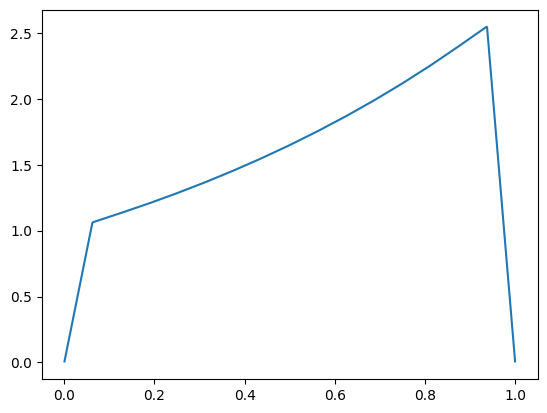

In [8]:
plot(u_true)

### The Weak Form

Define trial and test functions:

In [9]:
u = TrialFunction(V)
v = TestFunction(V)

We now define the bilinear and linear forms
$$ a(u,v) := \varepsilon^2(u',v') + (ru,v) 
\qquad and \quad 
l(v) L= (f,v).
$$
Note that we can represent $u'(x)$ and $v'(x)$ as `u.dx(0)` and `v.dx(0)`, where here the index says we are differentiating with respect to the first (and only) dimension.

In [10]:
a = (epsilon**2)*u.dx(0)*v.dx(0)*dx + r*u*v*dx
l = f(x[0])*v*dx

### Boundary conditions

It is easy to impose any reasonable boundary conditions you can think of. Here we'll use set homogeneous Dirichlet: 

In [11]:
BCs = DirichletBC(V, 0.0, "on_boundary")

### Solve

And we are ready to solve! Define a function to store the solution, and call the solver:

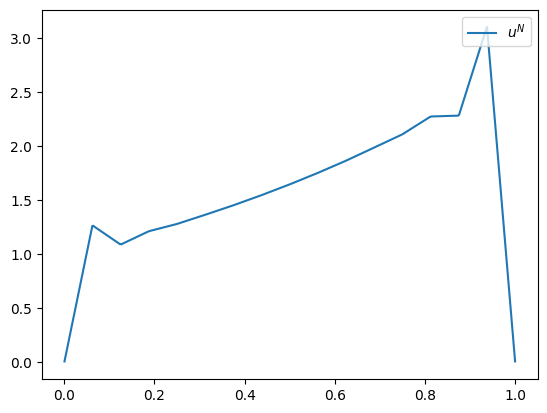

In [12]:
uN = Function(V)
solve(a == l, uN, bcs=BCs)
plot(uN, label="$u^N$")
plt.legend()

### Compute errors

We'll define a function $d(x)=u(x)-u^N(x)$ and compute the $L_2$, energy, and $\max$ norms of that.
* For $L_2$-type norms, apply the `dx` operator to form an integral, and then `assemble` that to evaluate.
* For maximum pointwise error, choose a set of points (e.g., the mesh points) and evaluate `d` at those, using the `at` method. (There are other approaches).

In [13]:
d = Function(V).interpolate(uN-u_true)

L2_error = sqrt(assemble( d**2*dx)) # same as L2=
H1_error = sqrt(assemble( d.dx(0)**2*dx))
a_error  = sqrt( float(epsilon)*H1_error**2.0 + L2_error**2.0)

xp = np.linspace(0,1,N+1) # points at which we compute errors
max_pw_error = max(np.abs(d.at(xp)))

print(f"Errors: L2={L2_error : 8.3e}, H1={H1_error : 8.3e}, Energy={a_error : 8.3e}, Max={max_pw_error: 8.3e}")

Errors: L2= 1.181e-01, H1= 3.790e+00, Energy= 3.969e-01, Max= 5.608e-01


### Plot solutions

While we can plot solutions using the `plot()` function, which is an interface to `matplotlib`. But if you are familiar with `matplotlib` it might be better to use it directly:

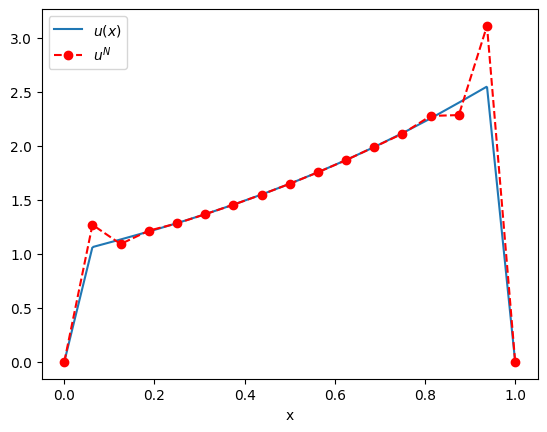

In [14]:
x_vals = mesh1D.coordinates.dat.data[:]

plot(u_true, label='$u(x)$') # true
plt.plot(x_vals, uN.at(x_vals),'r--o', label='$u^N$')  # use for small N
plt.xlabel("x")
plt.legend()

## A fitted mesh in 1D

We now what to compute solutions (and corresponding errors) on a fitted mesh. At this stage, it makes sense to wrap our solver in a function, so we can call it for different $\varepsilon$ and meshes.

### Solver as a function

In [19]:
def Solve_1DRD(epsilon, my_mesh, my_degree):
    V = FunctionSpace(my_mesh, "CG", my_degree)
    x = SpatialCoordinate(V)
    u = TrialFunction(V)
    v = TestFunction(V)
    a = (epsilon**2)*u.dx(0)*v.dx(0)*dx + r*u*v*dx
    l = f(x[0])*v*dx
    uN = Function(V)
    BCs = DirichletBC(V, 0.0, "on_boundary")
    solve(a == l, uN, bcs=BCs)
    return(uN)

Let's check if that works

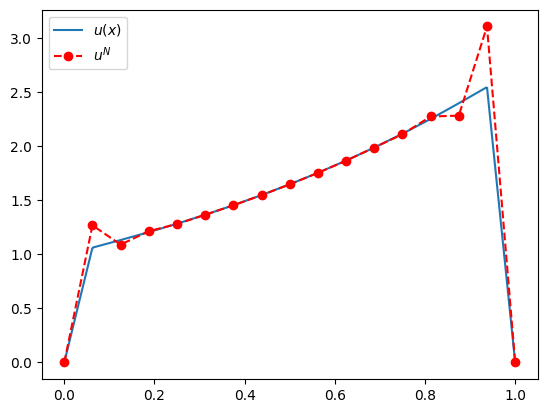

In [21]:
N = 16
epsilon = 1.0e-2
mesh1D = UnitIntervalMesh(N)
uN = Solve_1DRD(epsilon, mesh1D, 1)
x_vals = mesh1D.coordinates.dat.data[:]
plot(u_true, label='$u(x)$') # true
plt.plot(x_vals, uN.at(x_vals),'r--o', label='$u^N$')  # use for small N
plt.legend()

## Other things Firedrake can and cannot do

1. Many other elements are implemented; see https://www.firedrakeproject.org/variational-problems.html#supported-finite-elements. These include elemenst on triangles, tets, quads, and hex elements. 
2. dG elements are implemented, but only on conforming meshes.
3. The 'irksome' module adds support for RK-methods in time (and solver support).
4. Geometric multigrid 
5. Visualisation is limited (just an interface to `matplotlib`: use of Paraview recommended).
6. Nonlinear problems are represented in a natural way, but care is needed with solver options.
